In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim

In [2]:
# Hyper-parameters

learning_rate = 0.001

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees = 0, translate=(0.1, 0.1)),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomGrayscale(),
    # transforms.RandomPerspective(),
    transforms.ToTensor()]) #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

batch_size = 64

transform_test = transforms.Compose(
    [transforms.ToTensor()]) # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

torch.manual_seed(43)

def changelabel(y, p):
    if torch.rand(1).item() > p:
        return y

    newy = torch.randint(0,9,[1]).item()
    if newy == y:
        newy = 9
    return newy
target_transform = transforms.Lambda(lambda y : changelabel(y,0.5))

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train, target_transform=target_transform)
train_dl = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=4,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
test_dl = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=4,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

val_dl = test_dl

Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [4]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)
model = ResNet34().to(device)

cuda


In [5]:
from torch import Tensor
def sce(pred, labels, alpha, beta, num_classes, device):
    cross_entropy = torch.nn.CrossEntropyLoss()
    # CCE
    ce = cross_entropy(pred, labels)

    # RCE
    pred = F.softmax(pred, dim=1)
    pred = torch.clamp(pred, min=1e-7, max=1.0)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes).float().to(device)
    label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
    rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))

    # Loss
    loss = alpha * ce + beta * rce.mean()
    return loss
class SCELoss(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=10):
        super(SCELoss, self).__init__()
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes
        self.cross_entropy = torch.nn.CrossEntropyLoss()

    def forward(self, pred, labels) -> Tensor:
        return sce(pred, labels, self.alpha, self.beta, self.num_classes, self.device)


In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# criterion = SCELoss(0.1, 1)
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5, lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

curr_lr = learning_rate

In [7]:
loss_store_train =[]
loss_store_val = []
val_acc_store=[]
train_acc_store=[]
epoches=20
xaxis=np.arange(0.0,epoches)
for epoch in range(epoches): #I decided to train the model for 50 epochs
    train_loss = 0
    train_correct = 0
    train_samples = 0
    predictions = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        _, predictions = score.max(1)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        train_loss += loss.item()
        train_correct += (predictions == targets).sum()
        train_samples += predictions.size(0)
    print(f"In epoch {epoch+1}: Training Loss {train_loss/len(train_dl):.3f} and Training Accuracy {float(train_correct) / float(train_samples) * 100:.2f}")
    loss_store_train.append(train_loss/len(train_dl))
    train_acc_store.append(float(train_correct) / float(train_samples) * 100)
    
    
    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)
    
    model.eval()
    valid_loss = 0
    num_correct = 0
    num_samples = 0
    predictions = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with Validation accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        val_acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

In epoch 1: Training Loss 2.279 and Training Accuracy 17.20
Got 2721 / 10000 with Validation accuracy 27.21
In epoch 2: Training Loss 2.217 and Training Accuracy 20.48
Got 3882 / 10000 with Validation accuracy 38.82
In epoch 3: Training Loss 2.180 and Training Accuracy 23.44
Got 4232 / 10000 with Validation accuracy 42.32
In epoch 4: Training Loss 2.148 and Training Accuracy 25.76
Got 4751 / 10000 with Validation accuracy 47.51
In epoch 5: Training Loss 2.124 and Training Accuracy 27.85
Got 4689 / 10000 with Validation accuracy 46.89
In epoch 6: Training Loss 2.107 and Training Accuracy 29.21
Got 5505 / 10000 with Validation accuracy 55.05
In epoch 7: Training Loss 2.093 and Training Accuracy 30.66
Got 5807 / 10000 with Validation accuracy 58.07
In epoch 8: Training Loss 2.078 and Training Accuracy 31.50
Got 5899 / 10000 with Validation accuracy 58.99
In epoch 9: Training Loss 2.060 and Training Accuracy 32.53
Got 6054 / 10000 with Validation accuracy 60.54
In epoch 10: Training Loss 2

Text(0, 0.5, 'Accuracy')

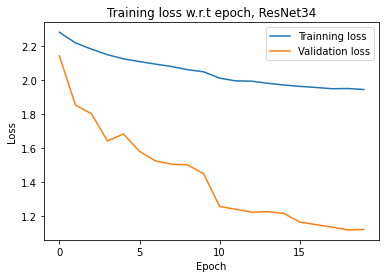

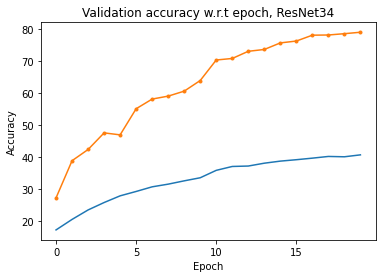

In [8]:
xi = list(range(epoches))
plt.xticks(range(0,epoches,5))
plt.figure(1)
plt.plot(xi,loss_store_train,label = 'Trainning loss')
plt.plot(xi,loss_store_val, label = 'Validation loss') 
plt.legend() 
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training loss w.r.t epoch, ResNet34') 
plt.figure(2)
plt.xticks(range(0,epoches,5))
plt.plot(xi,train_acc_store, label = 'Training Accuracy')
plt.plot(xi,val_acc_store,marker='.', label = 'Validation Accuracy')
plt.title('Validation accuracy w.r.t epoch, ResNet34') 
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')

In [9]:
filename = 'Resnet-34_50ce'
PATH = './' + filename + '.pth'
torch.save(model.state_dict(), PATH)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


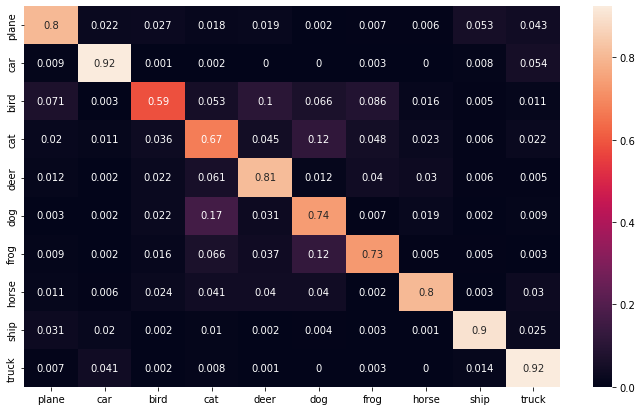

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []
model.eval()
# iterate over test data
for _, (data,targets) in enumerate(val_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        score = model(data)
        
        output = (torch.max(torch.exp(score), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = targets.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig(filename + '_confmat.png')

In [ ]:
model = model(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-4, lr=0.01)


In [ ]:
epoches=20
xaxis=np.arange(0.0,epoches)

for epoch in range(epoches): #I decided to train the model for 50 epochs
    loss_ep = 0
    model.train()
    for _, (data, targets) in enumerate(train_dl):
        data = data.to(device=device)
        targets = targets.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        score = model(data)
        loss = criterion(score,targets)
        loss.backward()
        optimizer.step()
        #scheduler.step()
        loss_ep += loss.item()
    print(f"Loss in epoch {epoch}: {loss_ep/len(train_dl):.3f}")
    loss_store_train1.append(loss_ep/len(train_dl))
    
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        num_correct = 0
        num_samples = 0
        for _, (data,targets) in enumerate(val_dl):
            data = data.to(device=device)
            targets = targets.to(device=device)
            ## Forward Pass
            score = model(data)
            _, predictions = score.max(1)
            loss2 = criterion(score,targets)
            valid_loss += loss2.item()
            
            num_correct += (predictions == targets).sum()
            num_samples += predictions.size(0)
        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}"
        )
        acc_store.append(float(num_correct) / float(num_samples) * 100)
    loss_store_val.append(valid_loss/len(test_dl))

KeyboardInterrupt: 